# Building a bar chart with draggable value of interest horizontal line

---

Below code aims to replicate interactive data visualisation to support probabilistic tasks as presented in:



&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


Bars represent mean value of a data sample. Vertical lines represent 95% confidence interval.
To compare each bar to a fixed value of interesdt, the user can move the horizontal line. Colours of bars will change to indicate if the mean (within a confidence interval) is likely to be higher or lower than value of interest. 

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import math
import random

In [2]:
# Generate Data Frame

np.random.seed(123)

df = pd.DataFrame([np.random.normal(33000,150000,3650), 
                   np.random.normal(40000,100000,3650), 
                   np.random.normal(42300,140000,3650), 
                   np.random.normal(37000,70000,3650),
                   np.random.normal(44000,90000,3650)],
                  index=[1992,1993,1994,1995,1996])

In [3]:
# Generate statistics for the Data Frame

class DataAnalysis:
    def __init__(self, df):
        self.df = df
    
    def __call__(self):
        self.mean, self.err, self.max, self.min = self.get_statistics()
        return [self.mean, self.err, self.max, self.min]
    
    def get_statistics(self):
        # Analyze data and prepare for plotting
        mean = list(df.mean(axis = 1))
        std = df.std(axis = 1)    

        # Calculate confidence interval using: https://www.mathsisfun.com/data/confidence-interval.html
        # Z value for 95% interval is 1.96
        # mean +/- 1.96 * (std)/sqrt(n)
        n = df.shape[1]

        #1.96*(std[i]/math.sqrt(len(df)))
        err = [1.96*(i/math.sqrt(n)) for i in std]

        # Generate .95 mean interval - will be used for comparision with value of interest
        max = list(map(lambda x, y: x + y, mean, err))
        min = list(map(lambda x, y: x - y, mean, err))
        
        return mean, err, max, min
    

In [4]:
# Build Bar Chart with draggable horizontal line

class DraggableLineBarChart:
    def __init__(self, df, mean, err, max, min):        
        
        # Statistics
        self.df = df
        self.mean = mean 
        self.err = err
        self.max = max
        self.min = min
        self.voi = self.mean[0]

        # Plot
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.canvas = self.ax.get_figure().canvas
        
        self.cmap, self.norm, self.bounds = self.colors_on_the_fly()
        self.colors = self.cmap(self.bar_colors(self.voi, self.min, self.max))
        self.fig.colorbar(mpl.cm.ScalarMappable(norm=self.norm, cmap=self.cmap), 
                          ax=self.ax, ticks=self.bounds)
        self.barchart = self.ax.bar(df.index, self.mean, yerr = self.err, 
                                    edgecolor='k', color=self.colors, capsize=5)
        
        # Draggable horizontal line
        self.fig.suptitle('Drag the line to define value of interest', fontsize=14)
        self.line = self.ax.axhline(self.voi, color='grey', picker=True, pickradius=5)
        self.ax.add_line(self.line)
        
        # Connect to events
        self.connect()

    def connect(self):
        # connect to all the events
        self.cidpress = self.canvas.mpl_connect(
            'button_press_event', self.on_press)
        self.cidrelease = self.canvas.mpl_connect(
            'button_release_event', self.on_release)
        self.cidmotion = self.canvas.mpl_connect(
            'motion_notify_event', self.on_motion)  
    
    def on_press(self, event):
        # on button press see if the mouse is over the line and store some data
        if event.inaxes != self.line.axes: return
        contains, attr = self.line.contains(event)
        if not contains: return        
        self.press = self.line.get_ydata()[0]

    def on_motion(self, event):
        # on motion move the line if the mouse is over the line
        if self.press is None: return
        if event.inaxes != self.line.axes: return
    
        ypress = self.press
        dy = event.ydata - ypress
        self.line.set_ydata([ypress+dy])
        
        self.voi = self.line.get_ydata()[0]
        colors = self.cmap(self.bar_colors(self.voi, self.min, self.max))

        counter = 0
        for bar in self.barchart:
            bar.set_facecolor(color = colors[counter])
            counter += 1

        self.ax.set_title(f'Value of interest: {round(self.voi)}')
        
    def on_release(self, event):
        # on release reset the press data
        self.press = None
        self.canvas.draw_idle()
    
    def colors_on_the_fly(self):
        n = 11  # Define number of labels
        cmap = plt.get_cmap('RdBu_r')  # Define the colormap
        
        # Extract all colors from the map and create new color map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        cmap = cmap.from_list('Blue to Red', cmaplist, cmap.N)
        
        # Generate a colormap index based on discrete intervals
        bounds = np.linspace(0,1,n+1).round(decimals=2)
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        
        return cmap, norm, bounds

    def bar_colors(self, voi, min, max):
        col = []
        for i in range(0,len(min)):
            normalized_color = ((voi - min[i]) / (max[i] - min[i]))
            col.append(normalized_color)           
        return col
          

<IPython.core.display.Javascript object>


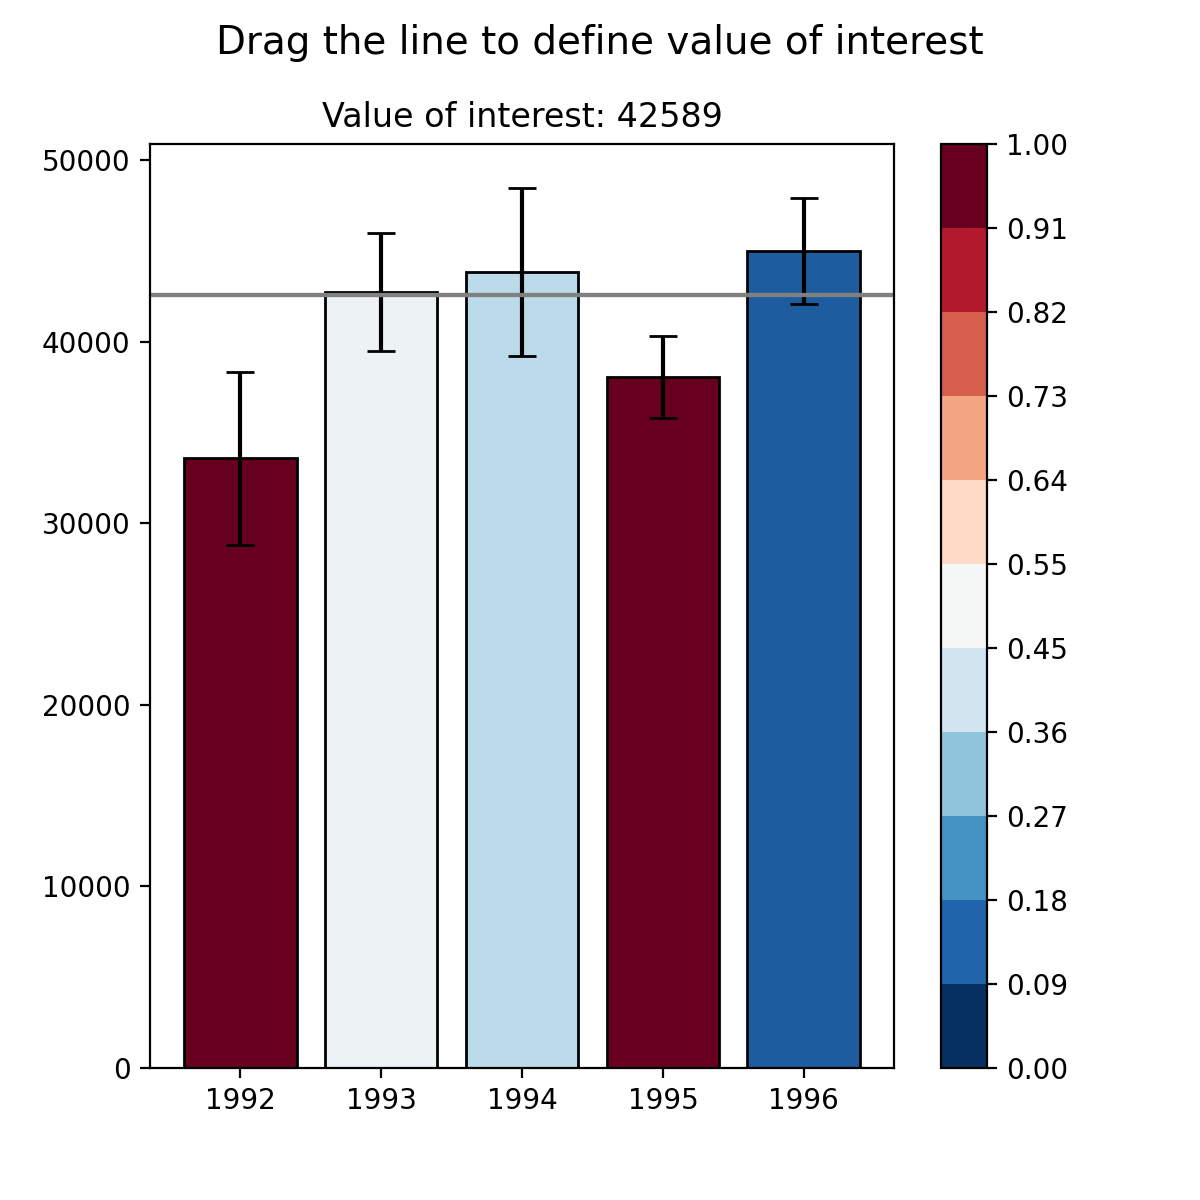

In [5]:
# Generate bar chart with draggable Value of Interest line

results = DataAnalysis(df)
results()
mean, err, max, min = results()
interactive_chart = DraggableLineBarChart(df, mean, err, max, min)
plt.show()
